# Digit Sequences

### Recognizing digit sequences from a simple synthetic dataset using TensorFlow 

---

The following notebook details my implementation of a Convolutional Neural Network to recognize sequences of digits in a synthetic dataset created from the MNIST dataset. The purpose of the notebook is to understand how the architecture of a network has to be changed to accomodate classification of multiple objects. I have broken the notebook into two parts as TensorFlow programs are usually structured into a **construction phase**, that assembles a graph, and an **execution phase** that uses a session to execute ops in the graph.

Let's start by importing some libraries and load our prepared dataset.

In [9]:
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import time
import os
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

print("Tensorflow version: " + tf.__version__)

Tensorflow version: 0.11.0


## Loading the data

Let's load the greyscale images created in our previous notebook

In [10]:
h5f = h5py.File('data/MNIST_synthetic.h5','r')

X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_test = h5f['valid_dataset'][:]
y_test = h5f['valid_labels'][:]
X_val = h5f['test_dataset'][:]
y_val = h5f['test_labels'][:]

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_test.shape, y_test.shape)
print('Test set', X_val.shape, y_val.shape)

h5f.close()

('Training set', (37500, 64, 64, 1), (37500, 5))
('Validation set', (2500, 64, 64, 1), (2500, 5))
('Test set', (10000, 64, 64, 1), (10000, 5))


## Helper functions

A helper function is a function that performs part of the computation of another function. Helper functions are used to make your programs easier to read by giving descriptive names to computations. They also let you reuse computations, just as with functions in general.

### Helper function for plotting images

Here is a simple helper function that will help us plot ``nrows`` * ``ncols`` images and their true and predicted labels.

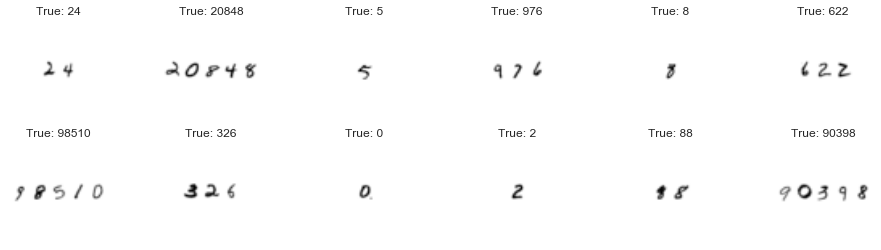

In [13]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    for i, ax in enumerate(axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        

# Display 2 rows with 6 images
plot_images(X_train, 2, 6, y_train);

### Helper functions for creating new variables

Functions for creating new [``TensorFlow Variables``](https://www.tensorflow.org/how_tos/variables/) in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [14]:
def conv_weight_variable(name, shape):
    return tf.get_variable(name, shape=shape,initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(name, shape):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    return tf.Variable(tf.constant(1.0, shape=shape))

### Helper function for creating a Convolutional Layer

This function creates a new convolutional layer in the computational graph for TensorFlow.

In [15]:
def conv_layer(input,             # The previous layer.
                n_channels,       # Num. channels in prev. layer.
                f_size,           # Width and height of each filter.
                n_filters,        # Number of filters.
                weight_name,      # Name of variable containing the weights
                pooling=True):    # Use 2x2 max-pooling.

    # Create weights and biases
    
    weights = conv_weight_variable(weight_name, [f_size, f_size, n_channels, n_filters])
    biases = bias_variable([n_filters])
    
    layer = tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='VALID')
    layer = tf.nn.relu(layer + biases)

    # Use pooling to down-sample the image resolution?
    if pooling:
        layer = tf.nn.max_pool(layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='VALID')

    return layer, weights

### Helper function for flattening a layer

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [16]:
def flatten_layer(layer):
    
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features

### Helper function for creating a new Fully-Connected Layer

This function creates a new fully-connected layer in the computational graph for TensorFlow.

In [17]:
def fc_layer(input,          # The previous layer.
            num_inputs,      # Num. inputs from prev. layer.
            num_outputs,     # Num. outputs.
            weight_name,     # Name of variable containing the weights
            relu=True):      # Use Rectified Linear Unit (ReLU)?
    
    # Create new weights and biases.
    weights = fc_weight_variable(weight_name, shape=[num_inputs, num_outputs])
    biases = bias_variable([num_outputs])

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

### Helper function for creating a new Prediction Layer

In [18]:
def softmax_function(input,         # Previous layer
                     num_inputs,    # Number of inputs from previous layer
                     num_outputs,   # Number of outputs
                     weight_name):  # Name of variable containing the weights
                 
    # Create weights and biases
    weights = fc_weight_variable(weight_name, [num_inputs, num_outputs])
    biases = bias_variable([num_outputs])
    
    # Softmax
    logits = tf.matmul(input, weights) + biases
    
    return logits, weights

## Data dimensions

The data dimensions are used in several places in the code below. In computer programming it is generally best to use variables and constants rather than having to hard-code specific numbers every time that number is used.

In [19]:
# The image size is 64 x 64 pixels
img_size = 64

# Number of channels: 1 because greyscale
num_channels = 1

# Number of digits
num_digits = 5

# Number of output labels
num_labels = 11

## Network configuration

The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [20]:
# Convolutional Layer 1
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 36 of these filters.

# Convolutional Layer 3
filter_size3 = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 48 of these filters.

# Fully-connected layer
fc_size = 64             # Number of neurons in fully-connected layer.

## Tensorflow Model

Let's build our tensorflow model step-by-step. The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to change the input to the graph.
* Model variables that are going to be optimized
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

### Placeholder Variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

In [21]:
# Images placeholder
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')

# Labels placeholder
y_true = tf.placeholder(tf.int64, shape=[None, num_digits], name='y_true')

To reduce overfitting, we will apply dropout after the pooling layer.

In [22]:
keep_prob = tf.placeholder(tf.float32)

### Convolutional Layer 1

Create the first convolutional layer. It takes x as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [23]:
conv_1, w_c1 = conv_layer(x, num_channels, filter_size1, num_filters1, 'w_c1', True)

conv_1

<tf.Tensor 'MaxPool:0' shape=(?, 30, 30, 16) dtype=float32>

### Convolutional Layer 2

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [24]:
conv_2, w_c2 = conv_layer(conv_1, num_filters1, filter_size2, num_filters2, 'w_c2', True)

conv_2

<tf.Tensor 'MaxPool_1:0' shape=(?, 13, 13, 32) dtype=float32>

### Convolutional Layer 3

In [25]:
conv_3, w_c3 = conv_layer(conv_2, num_filters2, filter_size3, num_filters3, 'w_c3', False)

conv_3

<tf.Tensor 'Relu_2:0' shape=(?, 9, 9, 64) dtype=float32>

### Droput

In [26]:
dropout = tf.nn.dropout(conv_3, keep_prob)

dropout

<tf.Tensor 'dropout/mul:0' shape=(?, 9, 9, 64) dtype=float32>

### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [27]:
flatten, num_features = flatten_layer(dropout)

flatten

<tf.Tensor 'Reshape:0' shape=(?, 5184) dtype=float32>

Check that the tensors now have shape (?, 16384) which means there's an arbitrary number of images which have been flattened to vectors of length 16384 each. Note that 16384 = 16 x 16 x 64

### Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [28]:
fc_1 = fc_layer(flatten, num_features, fc_size, 'w_fc1', relu=True)

fc_1

<tf.Tensor 'Relu_3:0' shape=(?, 64) dtype=float32>

Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128.

### Predicted Class

The fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes for each of the 5 digits. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [29]:
logits_1, w_s1 = softmax_function(fc_1, fc_size, num_labels, 'w_s1')
logits_2, w_s2 = softmax_function(fc_1, fc_size, num_labels, 'w_s2')
logits_3, w_s3 = softmax_function(fc_1, fc_size, num_labels, 'w_s3')
logits_4, w_s4 = softmax_function(fc_1, fc_size, num_labels, 'w_s4')
logits_5, w_s5 = softmax_function(fc_1, fc_size, num_labels, 'w_s5')

y_pred = [logits_1, logits_2, logits_3, logits_4, logits_5]

# The class-number is the index of the largest element.
y_pred_cls = tf.transpose(tf.argmax(y_pred, dimension=2))

### Cost Function

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

In [30]:
loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_1, y_true[:, 0]))
loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_2, y_true[:, 1]))
loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_3, y_true[:, 2]))
loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_4, y_true[:, 3]))
loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_5, y_true[:, 4]))

loss = loss1 + loss2 + loss3 + loss4 + loss5

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the [``AdamOptimizer``](https://www.tensorflow.org/api_docs/python/train/optimizers#AdamOptimizer) which is an advanced form of Gradient Descent. When training a model, it is often recommended to lower the learning rate as the training progresses. This function applies an exponential decay function to a provided initial learning rate.

In [31]:
# We use global_step as a counter variable
global_step = tf.Variable(0)

# The learning rate is initially set to 0.05
start_learning_rate = 0.1

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 10000, 0.96)

# Use the Adagrad optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

### Evaluation Metric

To evaluate the performance of our Convolutional Network we calculate the average accuracy across all samples

In [32]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

### Create TensorFlow Session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [25]:
session = tf.Session()

session

The variables for weights and biases must be initialized before we start optimizing them.

In [26]:
session.run(tf.initialize_all_variables())

## Optimization

There are many images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

In [27]:
# Batch size
batch_size = 64

# Number of steps between each update
display_step = 5000

# Dropout
keep_prob = 0.5

The easiest way to save and restore a model is to use a tf.train.Saver object

In [28]:
saver = tf.train.Saver()

save_dir = 'checkpoints/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'mnist_net2')

#'''If you want to restore model'''
#saver.restore(sess=session, save_path=save_path)
#print("Model restored")

'If you want to restore model'

In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [31]:
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for step in range(num_iterations):

        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: keep_prob}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every x iterations.
        if step % display_step == 0:
            
            # Calculate the accuracy on the training-set.
            batch_predictions = session.run(y_pred_cls, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (step, accuracy(batch_predictions, batch_labels)))
            
            # Calculate the accuracy on the validation-set
            val_predictions = session.run(y_pred_cls, {x: X_val, y_true: y_val, keep_prob: 1.})
            print("Validation accuracy: %.4f" % accuracy(val_predictions, y_val))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_dif = time.time() - start_time
    
    # Calculate the accuracy on the test-set
    test_predictions = session.run(y_pred_cls, {x: X_test, y_true: y_test, keep_prob: 1.})
    
    print("Test accuracy: %.4f" % accuracy(test_predictions, y_test))
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    saver.save(sess=session, save_path=save_path)
    print('Model saved in file: {}'.format(save_path))

Let's run 100,000 iterations and see how well our model performs.

In [32]:
optimize(num_iterations=200000)

Minibatch accuracy at step 0: 13.4375
Validation accuracy: 15.1344
Minibatch accuracy at step 5000: 56.2500
Validation accuracy: 59.3648
Minibatch accuracy at step 10000: 70.0000
Validation accuracy: 68.0720
Minibatch accuracy at step 15000: 72.5000
Validation accuracy: 74.7760
Minibatch accuracy at step 20000: 75.0000
Validation accuracy: 78.5536
Minibatch accuracy at step 25000: 71.2500
Validation accuracy: 80.3648
Minibatch accuracy at step 30000: 75.0000
Validation accuracy: 82.9504
Minibatch accuracy at step 35000: 85.9375
Validation accuracy: 85.6384
Minibatch accuracy at step 40000: 80.6250
Validation accuracy: 86.9296
Minibatch accuracy at step 45000: 85.3125
Validation accuracy: 88.2336
Minibatch accuracy at step 50000: 87.1875
Validation accuracy: 89.1040
Minibatch accuracy at step 55000: 90.0000
Validation accuracy: 89.6448
Minibatch accuracy at step 60000: 88.7500
Validation accuracy: 90.4576
Minibatch accuracy at step 65000: 90.9375
Validation accuracy: 91.3728
Minibatch a

### Testset performance

Let's plot some of the mis-classified examples in our testset and a confusion matrix showing how well our model is able to predict the different digits.

In [33]:
# Generate predictions for the testset
test_pred = session.run(y_pred_cls, feed_dict={x: X_test, y_true: y_test, keep_prob: 1.0})

test_pred

array([[ 4,  3, 10, 10, 10],
       [ 7,  4, 10, 10, 10],
       [ 0,  3,  9, 10, 10],
       ..., 
       [ 5, 10, 10, 10, 10],
       [ 6,  4,  5,  6,  8],
       [ 1,  4,  2,  7,  4]])

#### Correctly classified images

Let's find some correctly classified examples and plot the true and predicted label values

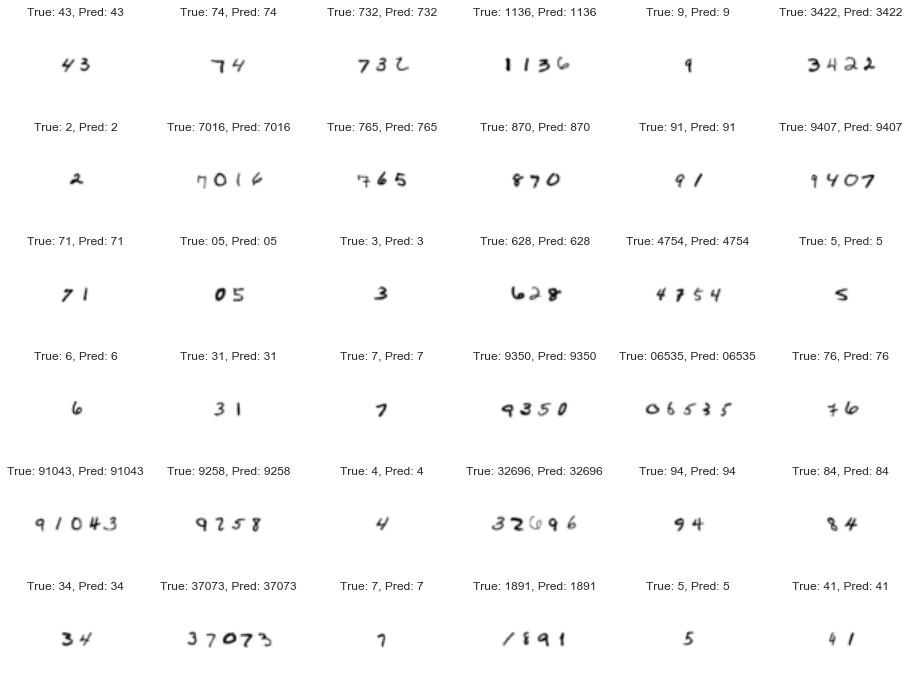

In [34]:
# Find the incorrectly classified examples
correct = np.array([(a==b).all() for a, b in zip(test_pred, y_test)])

# Select the incorrectly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 6, 6, cls_true, cls_pred);

#### Incorrectly classified images

Let's invert the boolean array and plot some of the incorrectly classified examples

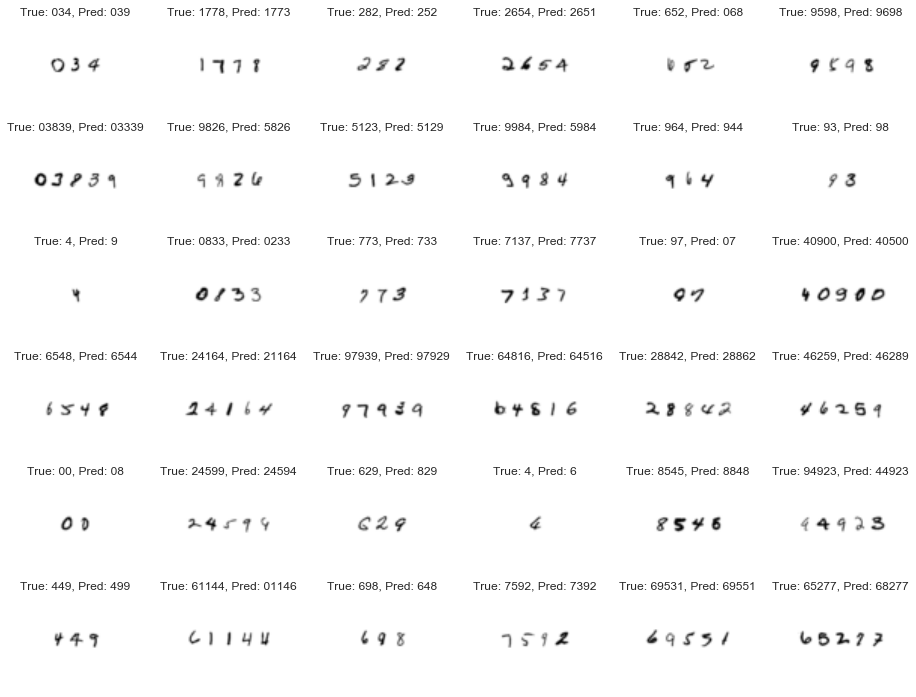

In [35]:
# Find the incorrectly classified examples
incorrect = np.invert(correct)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 6, 6, cls_true, cls_pred);

In [36]:
# Close session
session.close()